In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import glob
import os
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from datetime import datetime
import xarray as xr
from pint import UnitRegistry
ureg = UnitRegistry()
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from scipy.stats import t

In [2]:
# Function to extract epoch from the first few rows of the CSV file
def extract_epoch_from_header(file):
    # Read the first few lines to find the epoch (assuming it's in a comment or a header)
    with open(file, 'r') as f:
        skiprow = f.readline()
        skiprow = skiprow.strip().split()[0]
        for line in f:
            if "startdate:" in line.lower():  # Assuming the word 'epoch' is present in the line
                # Extract the epoch date (this assumes the date is the second item in the line)
                epoch = line.strip().split()[1]
                return int(skiprow)-1, epoch[0:4]+"-"+epoch[4:6]+"-"+epoch[6:8]+" "+epoch[8:10]+":"+epoch[10:12]+":"+epoch[12:14]
    return None  # Return None if no epoch is found

# Function to load and adjust time for each CSV
def load_and_adjust_time(file):
    # Try to extract the epoch from the header or a specific column
    nskiprows,epoch = extract_epoch_from_header(file)
   
    if epoch is None:
        raise ValueError(f"Could not find epoch for file: {file}")
   
    # Load the actual data (skipping header if necessary)
    df = pd.read_csv(file, skiprows=nskiprows,sep="\\s+")  # Adjust skiprows based on where the data starts
   
    # Convert 'time' column to a datetime, assuming it's in days
    # Adjust time column to start from the epoch time found in the file
    df['starttime_dt'] = pd.to_timedelta(df['starttime'], unit='D') + pd.Timestamp(epoch)
   
    # Return the adjusted DataFrame
    return df

In [3]:

# Path to the text file
# Path to the text file
file_path3 =  r"C:\\YEAR1\\NMVOC\\Data\\data_CO_CH4\\ch4_cmn_surface-insitu_443_allvalid.txt"
file_path4 =  r"C:\\YEAR1\\NMVOC\\Data\\data_CO_CH4\\ICOS_ATC_L2_L2-2024.1_CMN_8.0_CTS.CH4"

ch4_17 = pd.read_csv(file_path3,sep=" ",skiprows=189)
ch4_24 = pd.read_csv(file_path4, sep=";",skiprows=44)


In [4]:
#[mol mol-1], NOTA: deve esserci un refuso, dovrebbe essere nmol.mol-1
#CH4 dataset till 2017
ch4_17 = pd.read_csv(file_path3,sep=" ",skiprows=189)
ch4_17['datetime'] = pd.to_datetime(ch4_17[['year', 'month', 'day', 'hour']])
ch4_17 = ch4_17[ch4_17['qc_flag'] != 3]  # Filter rows where 'QCflag:comment' equals 3
ch4_17 = ch4_17[ch4_17['qc_flag']!= -999.999] 
ch4_17 = ch4_17[ch4_17['qc_flag']!= -9] 
ch4_17 = ch4_17[ch4_17['year']!= 2008] 
ch4_17 = ch4_17[ch4_17['year']!= 2009] 
ch4_17 = ch4_17[ch4_17['year']!= 2010] 
ch4_17 = ch4_17.drop(columns=["nvalue"]) 
#ch4_17 = ch4_17.drop(columns=["value_unc"]) 
ch4_17 = ch4_17.drop(columns=["second"])
ch4_17 = ch4_17.drop(columns=["year"])
ch4_17 = ch4_17.drop(columns=["month"])
ch4_17 = ch4_17.drop(columns=["day"])
ch4_17 = ch4_17.drop(columns=["hour"])
ch4_17 = ch4_17.drop(columns=["minute"])
#ch4_17 = ch4_17.drop(columns=["second"])
ch4_17 = ch4_17.drop(columns=["longitude"])
ch4_17 = ch4_17.drop(columns=["altitude"])
ch4_17 = ch4_17.drop(columns=["obspack_id"])
ch4_17 = ch4_17.drop(columns=["latitude"])
ch4_17 = ch4_17.drop(columns=["intake_height"])
ch4_17 = ch4_17.drop(columns=["obspack_num"])
ch4_17 = ch4_17.drop(columns=["unique_sample_location_num"])
ch4_17 = ch4_17.drop(columns=["qc_flag"])
ch4_17 = ch4_17.drop(columns=["datetimeISO"])
ch4_17 = ch4_17.drop(columns=["time"])
ch4_17 = ch4_17.drop(columns=["time_decimal"])
ch4_17 = ch4_17.drop(columns=["value_std_dev"])
ch4_17 = ch4_17.drop(columns=["icos_datalevel"])
ch4_17 = ch4_17.drop(columns=["icos_LTR"])
ch4_17 = ch4_17.drop(columns=["icos_CMR"])
ch4_17 = ch4_17.drop(columns=["icos_STTB"])

ch4_17.rename(columns={ "value":"ch4"},inplace=True)
ch4_17

,ch4,datetime
11558,1940.84,2011-05-24 13:00:00
11559,1955.85,2011-05-24 14:00:00
11560,1981.48,2011-05-24 15:00:00
11561,1989.29,2011-05-24 16:00:00
11562,1954.16,2011-05-24 17:00:00
...,...,...
89909,1971.50,2024-07-28 19:00:00
89910,1973.14,2024-07-28 20:00:00
89911,1983.59,2024-07-28 21:00:00
89912,2017.99,2024-07-28 22:00:00


In [5]:
#loop for rounding to the hours
ch4_17["datetime"] = [i.round("h") for i in ch4_17["datetime"]]

ch4_17

,ch4,datetime
11558,1940.84,2011-05-24 13:00:00
11559,1955.85,2011-05-24 14:00:00
11560,1981.48,2011-05-24 15:00:00
11561,1989.29,2011-05-24 16:00:00
11562,1954.16,2011-05-24 17:00:00
...,...,...
89909,1971.50,2024-07-28 19:00:00
89910,1973.14,2024-07-28 20:00:00
89911,1983.59,2024-07-28 21:00:00
89912,2017.99,2024-07-28 22:00:00


In [6]:
#[nmol.mol-¹]
#CH4 dataset between 2018 and 2024
ch4_24 = pd.read_csv(file_path4, sep=";",skiprows=44)
ch4_24 ['datetime'] = pd.to_datetime(ch4_24[['Year', 'Month', 'Day', 'Hour']])
ch4_24 = ch4_24[ch4_24['Flag'] != "N"]  # Filter rows where 'QCflag:comment' equals N
ch4_24 = ch4_24[ch4_24['Flag']!= "K"] 
ch4_24 = ch4_24[ch4_24['ch4']!= -9] 
ch4_24 = ch4_24.drop(columns=["Flag"]) 
ch4_24 = ch4_24.drop(columns=["Site"]) 
ch4_24 = ch4_24.drop(columns=["SamplingHeight"]) 
ch4_24 = ch4_24.drop(columns=["DecimalDate"]) 
ch4_24 = ch4_24.drop(columns=["NbPoints"]) 
ch4_24 = ch4_24.drop(columns=["InstrumentId"])
ch4_24 = ch4_24.drop(columns=["QualityId"])                            
ch4_24 = ch4_24.drop(columns=["LTR"])     
ch4_24 = ch4_24.drop(columns=["CMR"])                              
ch4_24 = ch4_24.drop(columns=["STTB"])    
ch4_24 = ch4_24.drop(columns=["QcBias"])  
ch4_24 = ch4_24.drop(columns=["QcBiasUncertainty"])                              
ch4_24 = ch4_24.drop(columns=["ch4-WithoutSpikes"]) 
ch4_24 = ch4_24.drop(columns=["Stdev-WithoutSpikes"]) 
ch4_24 = ch4_24.drop(columns=["NbPoints-WithoutSpikes"]) 
ch4_24 = ch4_24.drop(columns=["Stdev"]) 
ch4_24 = ch4_24.drop(columns=["Minute"]) 
ch4_24.rename(columns={"Year": "year", "Month": "month","Day":"day","Hour":"hour"},inplace=True)
ch4_24

,year,month,day,hour,ch4,datetime
168,2018,5,10,0,1944.79,2018-05-10 00:00:00
169,2018,5,10,1,1939.22,2018-05-10 01:00:00
170,2018,5,10,2,1931.26,2018-05-10 02:00:00
171,2018,5,10,3,1928.82,2018-05-10 03:00:00
172,2018,5,10,4,1932.80,2018-05-10 04:00:00
...,...,...,...,...,...,...
50265,2024,3,31,19,1994.03,2024-03-31 19:00:00
50266,2024,3,31,20,1992.84,2024-03-31 20:00:00
50267,2024,3,31,21,1990.84,2024-03-31 21:00:00
50268,2024,3,31,22,1990.17,2024-03-31 22:00:00


In [7]:
#loop for rounding to the hours
ch4_24["datetime"] = [i.round("h") for i in ch4_24["datetime"]]
#CO_17.index = CO_17["datetime"]
ch4_24 = ch4_24.drop(columns=["year"])
ch4_24 = ch4_24.drop(columns=["month"])
ch4_24 = ch4_24.drop(columns=["day"])
ch4_24 = ch4_24.drop(columns=["hour"])
ch4_24

,ch4,datetime
168,1944.79,2018-05-10 00:00:00
169,1939.22,2018-05-10 01:00:00
170,1931.26,2018-05-10 02:00:00
171,1928.82,2018-05-10 03:00:00
172,1932.80,2018-05-10 04:00:00
...,...,...
50265,1994.03,2024-03-31 19:00:00
50266,1992.84,2024-03-31 20:00:00
50267,1990.84,2024-03-31 21:00:00
50268,1990.17,2024-03-31 22:00:00


In [8]:

ch4_df = pd.concat([ch4_17, ch4_24]).sort_values('datetime').reset_index(drop=True)

In [9]:
ch4_df.index = ch4_df["datetime"]
# Resample data hourly and calculate the mean
ch4_hourly_means = ch4_df.resample('h').mean()
#remove lines with NaN
ch4_hourly_means.dropna(how='any', inplace=True)
ch4_hourly_means['CH4_ppb']=ch4_hourly_means['ch4']
ch4_hourly_means = ch4_hourly_means.drop(columns=["ch4"])
ch4_hourly_means


,datetime,CH4_ppb
datetime,,
2011-05-24 13:00:00,2011-05-24 13:00:00,1940.84
2011-05-24 14:00:00,2011-05-24 14:00:00,1955.85
2011-05-24 15:00:00,2011-05-24 15:00:00,1981.48
2011-05-24 16:00:00,2011-05-24 16:00:00,1989.29
2011-05-24 17:00:00,2011-05-24 17:00:00,1954.16
...,...,...
2024-07-28 19:00:00,2024-07-28 19:00:00,1971.50
2024-07-28 20:00:00,2024-07-28 20:00:00,1973.14
2024-07-28 21:00:00,2024-07-28 21:00:00,1983.59


In [10]:
# Reset index and reformat DataFrame

ch4_hourly_means = ch4_hourly_means.drop(columns=["datetime"])
ch4_hourly_means.head()

,CH4_ppb
datetime,
2011-05-24 13:00:00,1940.84
2011-05-24 14:00:00,1955.85
2011-05-24 15:00:00,1981.48
2011-05-24 16:00:00,1989.29
2011-05-24 17:00:00,1954.16


In [11]:
save_dir="C:\\YEAR1\\NMVOC\\Data\\" 

# Save final  DataFrame
output_file = os.path.join(save_dir, "processed_CH4.csv")
ch4_hourly_means.to_csv(output_file, index=True)

print(f"Saved final data to: {output_file}")

Saved final data to: C:\YEAR1\NMVOC\Data\processed_CH4.csv


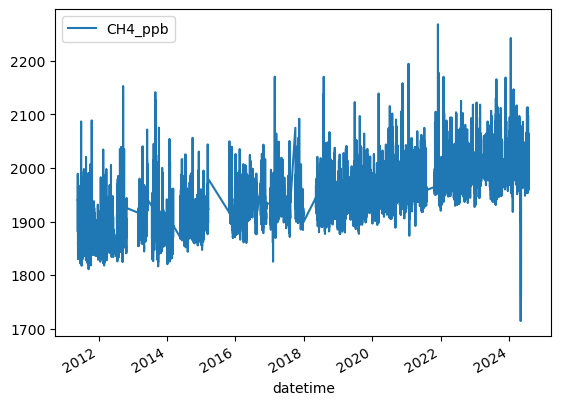

In [12]:
ch4_hourly_means.plot()

plt.show()

In [17]:
import pandas as pd

# Assume your DataFrame is named df and the date column is 'date'
# Convert to datetime if not already
#ch4_df['date'] = pd.to_datetime(ch4_df['date'])

# Define date range
start_date = '2021-01-01'
end_date = '2022-01-01'

# Filter the DataFrame
filtered_df = ch4_df[(ch4_df["datetime"] >= start_date) & (ch4_df["datetime"] <= end_date)]

# Optional: Check result
print(filtered_df.head())


                         ch4            datetime
datetime                                        
2021-01-01 00:00:00  1969.19 2021-01-01 00:00:00
2021-01-01 00:00:00  1969.19 2021-01-01 00:00:00
2021-01-01 01:00:00  1970.70 2021-01-01 01:00:00
2021-01-01 01:00:00  1970.70 2021-01-01 01:00:00
2021-01-01 02:00:00  1971.24 2021-01-01 02:00:00


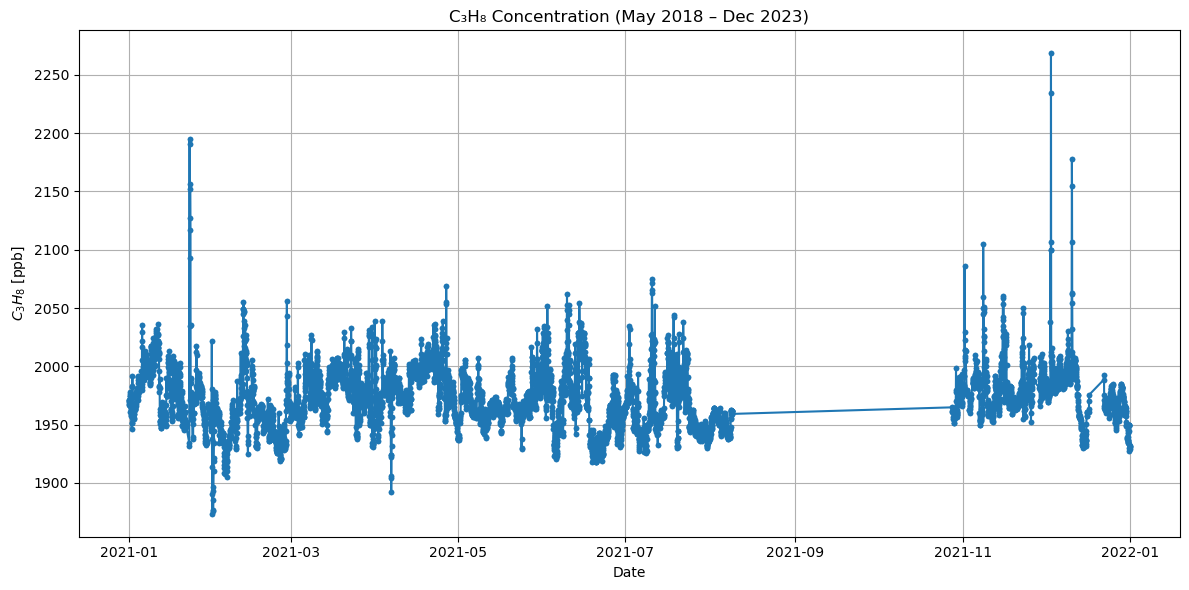

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(filtered_df["datetime"], filtered_df['ch4'], marker='.', linestyle='-')
plt.xlabel('Date')
plt.ylabel('$C_3H_8$ [ppb]')
plt.title('C₃H₈ Concentration (May 2018 – Dec 2023)')
plt.grid(True)
plt.tight_layout()
plt.show()
